In [32]:
import os
import datetime
import yaml
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [151]:
def idade(data):
    return datetime.date.today().year - datetime.datetime.strptime(data, "%d/%m/%Y").year

df = pd.DataFrame([])
for cpf in os.listdir("dados"):
    with open(os.path.join("dados", cpf), "r") as f:
        dados = yaml.load(f)
        dados.update({"cpf": cpf})
        df = df.append(dados, ignore_index=True)
df.loc[(df.tel_correlacao_crivo.isnull()), 'tel_correlacao_crivo'] = 0
df['idade'] = df['dt_nascimento'].map(idade)
df.loc[ df['idade'] <= 16, 'idade_faixa'] = 0
df.loc[(df['idade'] > 16) & (df['idade'] <= 32), 'idade_faixa'] = 1
df.loc[(df['idade'] > 32) & (df['idade'] <= 48), 'idade_faixa'] = 2
df.loc[(df['idade'] > 48) & (df['idade'] <= 64), 'idade_faixa'] = 3
df.loc[ df['idade'] > 64, 'idade_faixa'] = 4
df['email'] = df['email'].str[-9:].map( {'gmail.com': 0, 'yahoo.com': 1, 'tmail.com': 2} ).astype(int)
df.head()

,cpf,dt_nascimento,email,email_validado,fraude,nome,tel,tel_correlacao_crivo,tel_validado,idade,idade_faixa
0,10014264034,23/06/2017,2,1.0,0.0,Yasmin Isabella,71667735,0.0,0.0,0,0.0
1,10034277212,22/01/1943,1,0.0,0.0,Lara Vitor,64358159,0.0,0.0,74,4.0
2,10174195208,08/03/2012,1,0.0,0.0,Luiza Alice,76280134,0.0,0.0,5,0.0
3,10227468501,28/03/1966,0,0.0,0.0,Gabriela Isabella,81173335,1.0,1.0,51,3.0
4,10433319763,02/02/1955,2,0.0,0.0,Rafaela Felipe,67692520,1.0,1.0,62,3.0


In [57]:

#primeiros = int(0.25 * len(df))
#train_df = df.head(primeiros)
#test_df = df.tail(len(df) - primeiros)
#combine = [train_df, test_df]

In [152]:
df.describe()

,email,email_validado,fraude,tel_correlacao_crivo,tel_validado,idade,idade_faixa
count,1000.000000,1000.000000,1000.00000,1000.0000,1000.000000,1000.000000,1000.000000
mean,0.961000,0.253000,0.06100,0.1020,0.420000,40.831000,2.036000
std,0.812489,0.434948,0.23945,0.3028,0.493805,22.484127,1.377898
min,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.0000,0.000000,22.000000,1.000000
50%,1.000000,0.000000,0.00000,0.0000,0.000000,42.000000,2.000000
75%,2.000000,1.000000,0.00000,0.0000,1.000000,60.000000,3.000000
max,2.000000,1.000000,1.00000,1.0000,1.000000,80.000000,4.000000


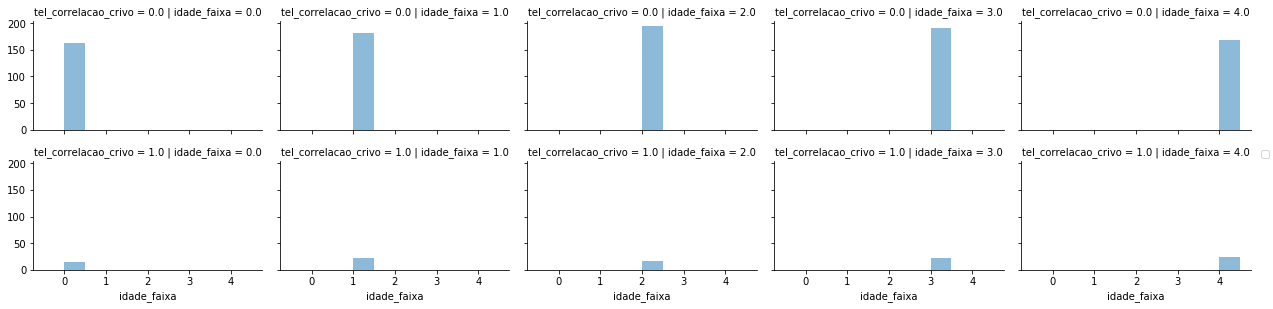

In [153]:
grid = sns.FacetGrid(df, row='tel_correlacao_crivo', col='idade_faixa', size=2.2, aspect=1.6)
grid.map(plt.hist, 'idade_faixa', alpha=.5, bins=2)
grid.add_legend()

In [156]:
df_clean = df.drop(['nome', 'dt_nascimento'], axis=1).copy()

primeiros = int(0.25 * len(df_clean))
train_df = df_clean.head(primeiros).copy()
test_df = df_clean.tail(len(df_clean) - primeiros).copy()

X_train = train_df.drop("fraude", axis=1)
Y_train = train_df["fraude"]

X_test  = test_df.drop("fraude", axis=1)

In [157]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [158]:
X_train.shape, Y_train.shape, X_test.shape

((250, 8), (250,), (750, 8))

In [159]:
Y_train[Y_train==1]

66     1.0
83     1.0
92     1.0
111    1.0
130    1.0
142    1.0
150    1.0
203    1.0
233    1.0
244    1.0
Name: fraude, dtype: float64

In [165]:
X_test['fraude'] = Y_pred

In [166]:
# Relacao da base com potencial de fraude
X_test[X_test['fraude']==1]

,cpf,email,email_validado,tel,tel_correlacao_crivo,tel_validado,idade,idade_faixa,fraude
310,37544275923,2,0.0,13928140,0.0,1.0,17,1.0,1.0
399,46030195598,2,0.0,16625094,0.0,1.0,31,1.0,1.0
503,55405134110,2,0.0,17878382,0.0,1.0,17,1.0,1.0
